Dataset Link: https://www.kaggle.com/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from matplotlib import pyplot as plt
import pickle

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
gpu_device = tf.config.list_physical_devices('GPU')[0]
gpu_device

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [2]:
tf.config.experimental.get_device_details(gpu_device)['device_name']

'NVIDIA GeForce GTX 1650 Ti'

In [3]:
tf.__version__

'2.6.0'

In [4]:
train_dataset_dir = ".\\Alzheimer_s Dataset\\train"
test_dataset_dir = ".\\Alzheimer_s Dataset\\test"
IMG_SIZE = (208, 176)
BATCH_SIZE = 16
EPOCHS = 500
PATIENCE = 20
COLOR_MODE = 'grayscale'
CHANNELS = 3 if COLOR_MODE == 'rgb' else 1
N_LABELS = len(os.listdir(train_dataset_dir))
DTYPE = tf.float32
MODEL_NAME = "Alzheimers_Model_2"

In [5]:
train_datagen = ImageDataGenerator(data_format='channels_last',
                                   validation_split=0.2,
                                   dtype=DTYPE)

test_datagen = ImageDataGenerator(data_format='channels_last',
                                  validation_split=0,
                                  dtype=DTYPE)

In [6]:
train_generator = train_datagen.flow_from_directory(directory=train_dataset_dir,
                                                    target_size=IMG_SIZE,
                                                    color_mode=COLOR_MODE,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE)

Found 4098 images belonging to 4 classes.


In [7]:
val_generator = train_datagen.flow_from_directory(directory=train_dataset_dir,
                                                  target_size=IMG_SIZE,
                                                  color_mode=COLOR_MODE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation',
                                                  batch_size=BATCH_SIZE)

Found 1023 images belonging to 4 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(directory=test_dataset_dir,
                                                  target_size=IMG_SIZE,
                                                  color_mode=COLOR_MODE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training',
                                                  batch_size=BATCH_SIZE)

Found 1279 images belonging to 4 classes.


In [9]:
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, CHANNELS)),
    
    preprocessing.Rescaling(scale= 1.0 / 255.0),
    
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Flatten(),
    
    layers.Dense(units=512, activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(units=256, activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(units=128, activation=layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(units=N_LABELS)
    
])

model._name = MODEL_NAME

In [10]:
lr_scheduler = keras.optimizers.schedules.InverseTimeDecay(3e-4, decay_steps=len(train_generator), decay_rate=0.5)

monitor = 'val_acc'
early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=PATIENCE, restore_best_weights=True)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=f"{MODEL_NAME}.hdf5",
                                                          monitor=monitor,
                                                          save_best_only=True,
                                                          save_freq='epoch',
                                                          verbose=1)
callbacks = [early_stopping, best_checkpoint]

keras.utils.plot_model(model, to_file=f"{MODEL_NAME} Structure.png", show_shapes=True)

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[keras.metrics.CategoricalAccuracy(name='acc')])

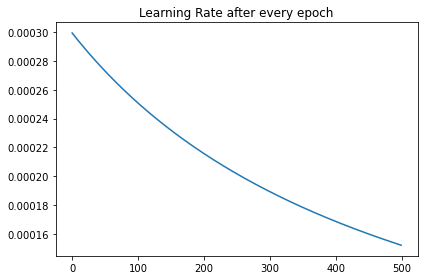

In [11]:
plt.figure()
plt.plot([lr_scheduler(step=x) for x in range(1, EPOCHS+1)])
plt.title("Learning Rate after every epoch")
plt.tight_layout()
plt.show()

In [12]:
model.summary()

Model: "Alzheimers_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 208, 176, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 208, 176, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 176, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 208, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 88, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 88, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 104, 88, 64)

In [13]:
train = model.fit(train_generator,
                  epochs=EPOCHS,
                  verbose=1,
                  workers=-1,
                  use_multiprocessing=True,
                  validation_data=val_generator,
                  callbacks=callbacks)

Epoch 1/500
257/257 [==============================] - 38s 125ms/step - loss: 1.3218 - acc: 0.5063 - val_loss: 1.6646 - val_acc: 0.5005

Epoch 00001: val_acc improved from -inf to 0.50049, saving model to Alzheimers_Model_2.hdf5
Epoch 2/500
257/257 [==============================] - 30s 116ms/step - loss: 1.0863 - acc: 0.5705 - val_loss: 3.5749 - val_acc: 0.3500

Epoch 00002: val_acc did not improve from 0.50049
Epoch 3/500
257/257 [==============================] - 30s 115ms/step - loss: 0.8576 - acc: 0.6840 - val_loss: 2.9115 - val_acc: 0.3460

Epoch 00003: val_acc did not improve from 0.50049
Epoch 4/500
257/257 [==============================] - 30s 115ms/step - loss: 0.6828 - acc: 0.7421 - val_loss: 3.3037 - val_acc: 0.3587

Epoch 00004: val_acc did not improve from 0.50049
Epoch 5/500
257/257 [==============================] - 29s 115ms/step - loss: 0.6026 - acc: 0.7831 - val_loss: 1.5273 - val_acc: 0.3969

Epoch 00005: val_acc did not improve from 0.50049
Epoch 6/500
257/257 [==

In [14]:
model = keras.models.load_model(f"{MODEL_NAME}.hdf5")

In [15]:
test = model.evaluate(test_generator,
                      workers=-1,
                      use_multiprocessing=True,
                      verbose=1)

80/80 [==============================] - 13s 155ms/step - loss: 1.2776 - acc: 0.6787


In [16]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,1.321823,0.506345,1.664609,0.500489
1,1.086297,0.570522,3.574944,0.349951
2,0.857579,0.683992,2.911538,0.346041
3,0.682847,0.742069,3.303733,0.358749
4,0.602625,0.783065,1.527294,0.396872


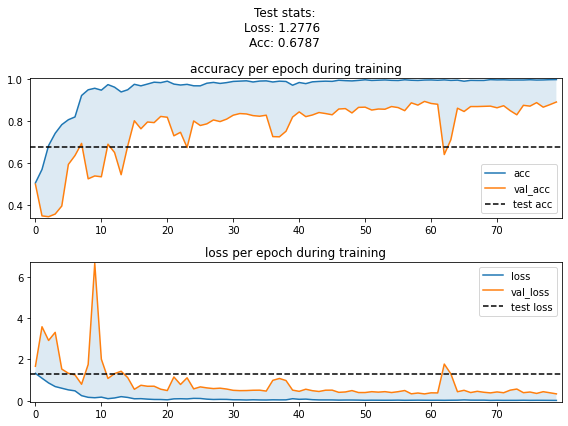

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(train_history['acc'], label='acc')
ax[0].plot(train_history['val_acc'], label='val_acc')
ax[0].fill_between(x=train_history.index, y1=train_history['acc'], y2=train_history['val_acc'], alpha=0.15)
ax[0].axhline(test[1], color='black', label='test acc', linestyle='--')
ax[0].legend(loc='best')
ax[0].margins(x=0.01, y=0.01)
ax[0].set_title('accuracy per epoch during training')

ax[1].plot(train_history['loss'], label='loss')
ax[1].plot(train_history['val_loss'], label='val_loss')
ax[1].fill_between(x=train_history.index, y1=train_history['loss'], y2=train_history['val_loss'], alpha=0.15)
ax[1].axhline(test[0], color='black', label='test loss', linestyle='--')
ax[1].legend(loc='best')
ax[1].margins(x=0.01, y=0.01)
ax[1].set_title('loss per epoch during training')

plt.suptitle(f"Test stats:\nLoss: {round(test[0], 4)} \nAcc: {round(test[1], 4)}")
plt.tight_layout()
plt.show()